In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

from pprint import pprint
from langdetect import detect

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel

from bs4 import BeautifulSoup

import ast
from collections import Counter
from operator import add

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.corpus import wordnet
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript'])

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /home/justin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/justin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/justin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/justin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/justin/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Preprocessing

In [3]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))

def preprocess(sentences):
    result = []
    
    for sent in sentences:
        lemmas = []
        # tokenize
        tokens = gensim.utils.simple_preprocess(sent)
        for token in tokens:
            lemma = lemmatize_stemming(token)
            # remove stopwords
            if lemma not in stop_words:
                lemmas.append(lemma)
#         # POS tagging
#         nltk_tagged = nltk.pos_tag(lemmas)
#         for word, tag in nltk_tagged:
#             # only keep nouns
#             if tag.startswith('N'):
#                 result.append(word)
        # Without POS tagging
        result += lemmas
    return result

In [4]:
# Preprocess texts in the list
def preprocess_texts(ls):
    parsed_ls = []
    if len(ls) > 0:
        for i in range(len(ls)):
            txt = str(ls[i])
            # Only include non-empty sentences with length > 1
            if len(txt) > 1 and txt != ' ':
                txt = remove_sp_char(txt)
                txt = remove_links(txt)
                txt = remove_email(txt)
                txt = remove_single_char(txt)
                txt = remove_multi_spaces(txt)
                txt = txt.strip()
                if len(txt) > 1:
                    txt = remove_noneng(txt)
                    if txt != '':
                        parsed_ls.append(txt)
        return parsed_ls
    else:
        return []

In [5]:
def remove_multi_spaces(text):
    return re.sub(' +', ' ', text)

In [6]:
def remove_single_char(text):
    return re.sub('(^| ).( |$)', '', text)

In [7]:
# Remove special characters in the text
def remove_sp_char(text):
    return re.sub('[^0-9a-zA-Z]+', ' ', text)

In [8]:
# Remove URL links in the text
def remove_links(text):
    text = re.sub('(?:https?://)?(?:www)?(\S*?\.onion)\b', '', text)
    text = re.sub('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', text)
    return text

In [9]:
# Remove email addressed in the text
def remove_email(text):
    return re.sub('\S*@\S*\s?', '', text)

In [10]:
# Replace non-english sentences with ''
def remove_noneng(text):
    try:
        lang = detect(text)
        if lang != 'en':
            return ''
        else:
            return text
    except:
        return ''

In [ ]:
def get_domain(url):
    url = str(url)
    result = re.findall('^(?:https?\:\/\/)?[\w\-\.]+\.onion', url)
    if len(result) < 1:
        return 'NA'
    else:
        return result[0]

In [11]:
## Categories ##
# 1: Market: Drug, gun, 
# 2: Counterfeit: counterfeit credit cards, money, ID
# 3: Services: Hosting service, forum, email, pastebin, file-sharing
# 4: Security: Security-related information, tutorials or services, leaked data
# 5: Porn: Hosting pornographic material
# 6: Cryptocurrency
# 7: NoAccess: Login, Down, Empty
# 8: Other: Cannot be classified in any other category (e.g. personal blog)

In [12]:
# Dictionary of conversion of categories
conversion_dict = {
    'Art': 'Other',
    'Casino': 'Services',
    'Counterfeit Credit-Cards': 'Counterfeit',
    'Counterfeit Money': 'Counterfeit',
    'Counterfeit Personal-Identification': 'Counterfeit',
    'Cryptocurrency': 'Cryptocurrency',
    'Cryptolocker': 'Security',
    'Down': 'NoAccess',
    'Drugs': 'Market',
    'Empty': 'NoAccess',
    'Forum': 'Services',
    'Hacking': 'Security',
    'Hosting': 'Services',
    'Leaked-Data': 'Services',
    'Library': 'Other',
    'Locked': 'NoAccess',
    'Marketplace': 'Market',
#     'Onion Directory/Wiki': ['directory', 'dir', 'wiki'],
    'Personal': 'Other',
    'Politics': 'Other',
    'Porno': 'Porn',
    'Religion': 'Other',
    'Services': 'Services',
    'Social-Network': 'Services',
    'Violence': 'Market',
    'Other': 'Other'
}

In [13]:
# Read input data
df_trainset_orig = pd.read_csv('../data/trainset_orig.csv')
df_trainset_verified = pd.read_csv('../data/trainset_verified.csv')
df_predictset_orig = pd.read_csv('../data/predict_set_orig.csv')
df_predictset_verified = pd.read_csv('../data/predict_set_verified.csv')
df_trainset_orig.drop(columns='Unnamed: 0', inplace=True)
df_trainset_verified.drop(columns='Unnamed: 0', inplace=True)
df_predictset_orig.drop(columns='Unnamed: 0', inplace=True)
df_predictset_verified.drop(columns='Unnamed: 0', inplace=True)

# Combine original trainset with verified class and language
# convert the string representation of a list into a list
df_trainset_orig['body_text'] = df_trainset_orig['body_text'].apply(ast.literal_eval)
df_trainset_orig['body_token'] = df_trainset_orig['body_token'].apply(ast.literal_eval)
df_trainset_verified['main_class'] = df_trainset_verified['main_class'].apply(lambda x: x.strip())
df_trainset_combined = df_trainset_orig[['url', 'title', 'body_text', 'body_token']]
df_trainset_combined['language'] = df_trainset_verified['language']
df_trainset_combined['url'] = df_trainset_combined['url'].apply(lambda x: [x])
df_trainset_combined['class'] = df_trainset_verified['main_class'].apply(lambda x: conversion_dict[x])

# Combine original predict set with verified class and language
df_predictset_orig['url'] = df_predictset_orig['url'].apply(ast.literal_eval)
df_predictset_orig['title'] = df_predictset_orig['title'].apply(ast.literal_eval)
df_predictset_orig['body_text'] = df_predictset_orig['body_text'].apply(ast.literal_eval)
df_predictset_orig['body_token'] = df_predictset_orig['body_token'].apply(ast.literal_eval)
df_predictset_combined = df_predictset_orig[['url', 'title', 'body_text', 'body_token']]
df_predictset_combined['title'] = df_predictset_combined['title'].apply(lambda x: x[0])
df_predictset_combined['language'] = df_predictset_verified['language_verified']
df_predictset_combined['class'] = df_predictset_verified['predict_class_verified']

In [14]:
df_trainset_combined

,url,title,body_text,body_token,language,class
0,[wwjewp6ca4rkudyj.onion],\n Frënn vun der Ënn - Index\n,"[Frënn vun der Ënn - Index, Skip to main conte...","[frënn, vun, der, ënn, index, skip, content, e...",en,Services
1,[u76xgym22s4adf55.onion],PayPal Master: Home,"[PayPal Master: Home, Contact us at: ppmaster@...","[master, home, contact, ppmaster, deepdarkmail...",en,Counterfeit
2,[2hftxvyft7dl3fk2.onion],Umbrella Escrow,"[Umbrella Escrow, Start new escrow, View exist...","[umbrella, escrow, escrow, view, escrow, instr...",en,Cryptocurrency
3,[elherbotsiddarol.onion],ElHerbolario,"[ElHerbolario, My Account, Blog, PGP, Sitemap,...","[elherbolario, account, blog, pgp, sitemap, nb...",en,Market
4,[yermrrzeg4fusqx5.onion],anonymous OnionMail Server,"[anonymous OnionMail Server, anonymous OnionMa...","[onionmail, server, onionmail, serveronion, ma...",en,Services
...,...,...,...,...,...,...
981,[aaaaa5r6ckox3y7s.onion],Money Master - MoneyGram - Moneybookers - West...,[Money Master - MoneyGram - Moneybookers - Wes...,"[money, master, moneygram, moneybook, union, g...",en,Counterfeit
982,[directdal7bourmy.onion],Onion Link Dir,"[Onion Link Dir, Onion Link Directory, Introdu...","[link, dir, link, directori, introduct, point,...",en,Services
983,[ohusanrieoxsxlmh.onion],Lintian Reports,"[Lintian Reports, Lintian Reports, Maintainers...","[report, report, maintain, tag, packag, expert...",en,Services
984,[mewmewmtgq7jda2i.onion],Me0w.net,"[Me0w.net, Browse gopher menu]","[net, brows, menu]",da,NoAccess


In [15]:
df_predictset_combined

,url,title,body_text,body_token,language,class
0,[mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxpk...,! CLONED CARDS !,"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...",en,Counterfeit
1,[he22pncoselnm54h.onion],$$ The Green Machine $$ - Error,[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]",en,NoAccess
2,[2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg2...,$$$ Credit Cards | PayPal | Wester Union | Mon...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...",en,Counterfeit
3,[darkfailllnkf4vf.onion],&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...",en,Services
4,[rvy6qmlqfstv6rlz.onion],&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...",de,Services
...,...,...,...,...,...,...
1162,[ctzzqqimlfamyhrc.onion],| TheYOSH.nl,"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...",en,Services
1163,[grrmailb3fxpjbwm.onion],✉ Guerrilla Mail on Tor,"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...",en,Services
1164,[greenegbqkyk3ois.onion],✔ Legit Carding Services ♛ Money Transfer Worl...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...",en,Counterfeit
1165,"[horoiomuy6xignjv.onion, qty3gmiq3zhs7whorla4y...",约伊兹的萌狼乡手札,"[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...",cn,Services


In [16]:
df_list = [df_trainset_combined, df_predictset_combined]
df_combined = pd.concat(df_list)
df_combined.reset_index(inplace=True)
# Drop old body tokens column
df_combined.drop(columns=['body_token', 'index'], inplace=True)
# Only select english websites since our language models are trained on English data
df_combined = df_combined[df_combined['language'] == 'en']
# Only keep unique sentences
df_combined['body_text'] = df_combined['body_text'].apply(lambda x: list(set(x)))
# Reset index
df_combined.reset_index(inplace=True)
df_combined.drop(columns=['index'], inplace=True)
df_combined

,url,title,body_text,language,class
0,[wwjewp6ca4rkudyj.onion],\n Frënn vun der Ënn - Index\n,[We provide high-bandwidth Tor nodes all over ...,en,Services
1,[u76xgym22s4adf55.onion],PayPal Master: Home,"[$2000 PP Transfer to PP or Skrill, $5000 PP T...",en,Counterfeit
2,[2hftxvyft7dl3fk2.onion],Umbrella Escrow,"[View existing escrow, Fees, • After the inspe...",en,Cryptocurrency
3,[elherbotsiddarol.onion],ElHerbolario,"[To display site correctly, Javascript enabled...",en,Market
4,[yermrrzeg4fusqx5.onion],anonymous OnionMail Server,"[Rulez, To anonymous, anonymous OnionMail Serv...",en,Services
...,...,...,...,...,...
1981,[5wkkhgqtity7bhdf.onion],walletGenerator - Universal Paper wallet gener...,"[Wallet Details, 05.2014 --, Public Address, S...",en,Cryptocurrency
1982,[ctzzqqimlfamyhrc.onion],| TheYOSH.nl,"[Website update + upgrade, Page, | TheYOSH.nl,...",en,Services
1983,[grrmailb3fxpjbwm.onion],✉ Guerrilla Mail on Tor,[sharklasers.comgrr.laguerrillamail.bizguerril...,en,Services
1984,[greenegbqkyk3ois.onion],✔ Legit Carding Services ♛ Money Transfer Worl...,"[AmericanExpress PrePaid Cards, $55.00 $45.00,...",en,Counterfeit


In [17]:
# Check the lengths
lens = [(i, len(sent)) for i, sent in enumerate(df_combined['body_text'])]
big_lens = [(i, l) for i, l in lens if l > 1000]
big_lens

[(51, 2220),
 (152, 1557),
 (367, 7207),
 (483, 2033),
 (654, 3490),
 (784, 4234),
 (897, 1844),
 (937, 2697),
 (939, 2528),
 (947, 1360),
 (981, 4404),
 (1085, 1979),
 (1237, 1607),
 (1275, 3646),
 (1309, 2253),
 (1320, 1116),
 (1333, 1054),
 (1335, 1571),
 (1362, 1162),
 (1387, 1286),
 (1397, 2682),
 (1406, 2726),
 (1529, 4312),
 (1552, 3569),
 (1580, 3189),
 (1581, 1815),
 (1738, 4956),
 (1749, 1087),
 (1906, 6288),
 (1934, 1827),
 (1939, 3476),
 (1969, 1195),
 (1973, 2033)]

In [18]:
# Remove special chars, URL links, email addresses,non-english sentences and empty sentences
df_combined['body_text'] = df_combined['body_text'].apply(preprocess_texts)
# Only keep unique processed texts
df_combined['body_text'] = df_combined['body_text'].apply(lambda x: list(set(x)))
# Generate tokens based on texts
df_combined['body_token'] = df_combined['body_text'].map(preprocess)
df_combined = df_combined[['url', 'title', 'body_text', 'body_token', 'language', 'class']]
df_combined

,url,title,body_text,body_token,language,class
0,[wwjewp6ca4rkudyj.onion],\n Frënn vun der Ënn - Index\n,[support FVDE because even small organizations...,"[support, fvde, becaus, even, small, organ, co...",en,Services
1,[u76xgym22s4adf55.onion],PayPal Master: Home,[Questions Telegram us at httpsme ppmasteroffi...,"[question, telegram, u, httpsme, avail, respon...",en,Counterfeit
2,[2hftxvyft7dl3fk2.onion],Umbrella Escrow,"[View existing escrow, Buyer starts an escrow ...","[view, exist, escrow, buyer, start, escrow, se...",en,Cryptocurrency
3,[elherbotsiddarol.onion],ElHerbolario,"[Thanks, Fran ais Tutoriel, Listings price dro...","[thank, fran, ai, tutoriel, list, price, drop,...",en,Market
4,[yermrrzeg4fusqx5.onion],anonymous OnionMail Server,"[To anonymous, anonymous OnionMail Server, Inf...","[anonym, anonym, onionmail, server, info, encr...",en,Services
...,...,...,...,...,...,...
1981,[5wkkhgqtity7bhdf.onion],walletGenerator - Universal Paper wallet gener...,"[Firefox 21 may 2013, English, Add support for...","[firefox, may, english, add, support, alqo, co...",en,Cryptocurrency
1982,[ctzzqqimlfamyhrc.onion],| TheYOSH.nl,[The last month the livecounter theyosh nl web...,"[last, month, livecount, theyosh, nl, websit, ...",en,Services
1983,[grrmailb3fxpjbwm.onion],✉ Guerrilla Mail on Tor,"[Your Email Address is, Javascript is disabled...","[email, address, disabl, featur, avail, thank,...",en,Services
1984,[greenegbqkyk3ois.onion],✔ Legit Carding Services ♛ Money Transfer Worl...,"[AmericanExpress PrePaid Cards, Hacked US Mast...","[americanexpress, prepaid, card, hack, u, mast...",en,Counterfeit


In [19]:
# Count number of clusters in each category
df_combined_count = df_combined[['title', 'class']].groupby(['class']).count()
df_combined_count = df_combined_count.sort_values(by=['title'], ascending=False)
df_combined_count.reset_index(inplace=True)
df_combined_count

,class,title
0,Services,602
1,Counterfeit,531
2,Market,205
3,NoAccess,205
4,Cryptocurrency,127
5,Other,113
6,Security,73
7,Porn,71


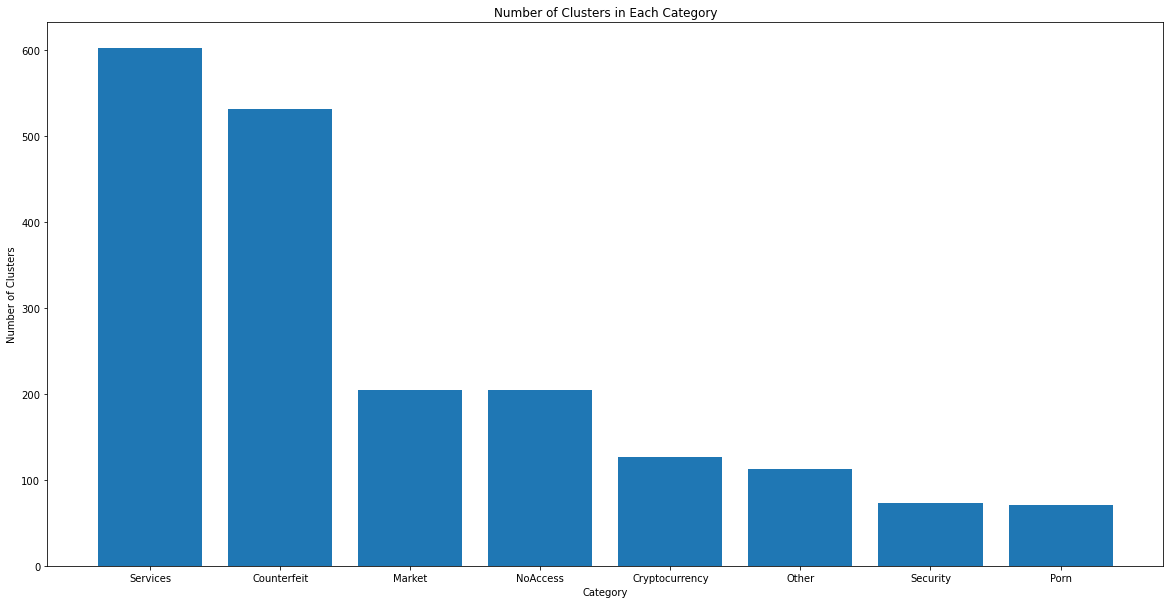

In [20]:
plt.figure(figsize=(20,10))
plt.bar(df_combined_count['class'], df_combined_count['title'])
plt.xlabel("Category")
plt.ylabel("Number of Clusters")
plt.title("Number of Clusters in Each Category")
plt.show()

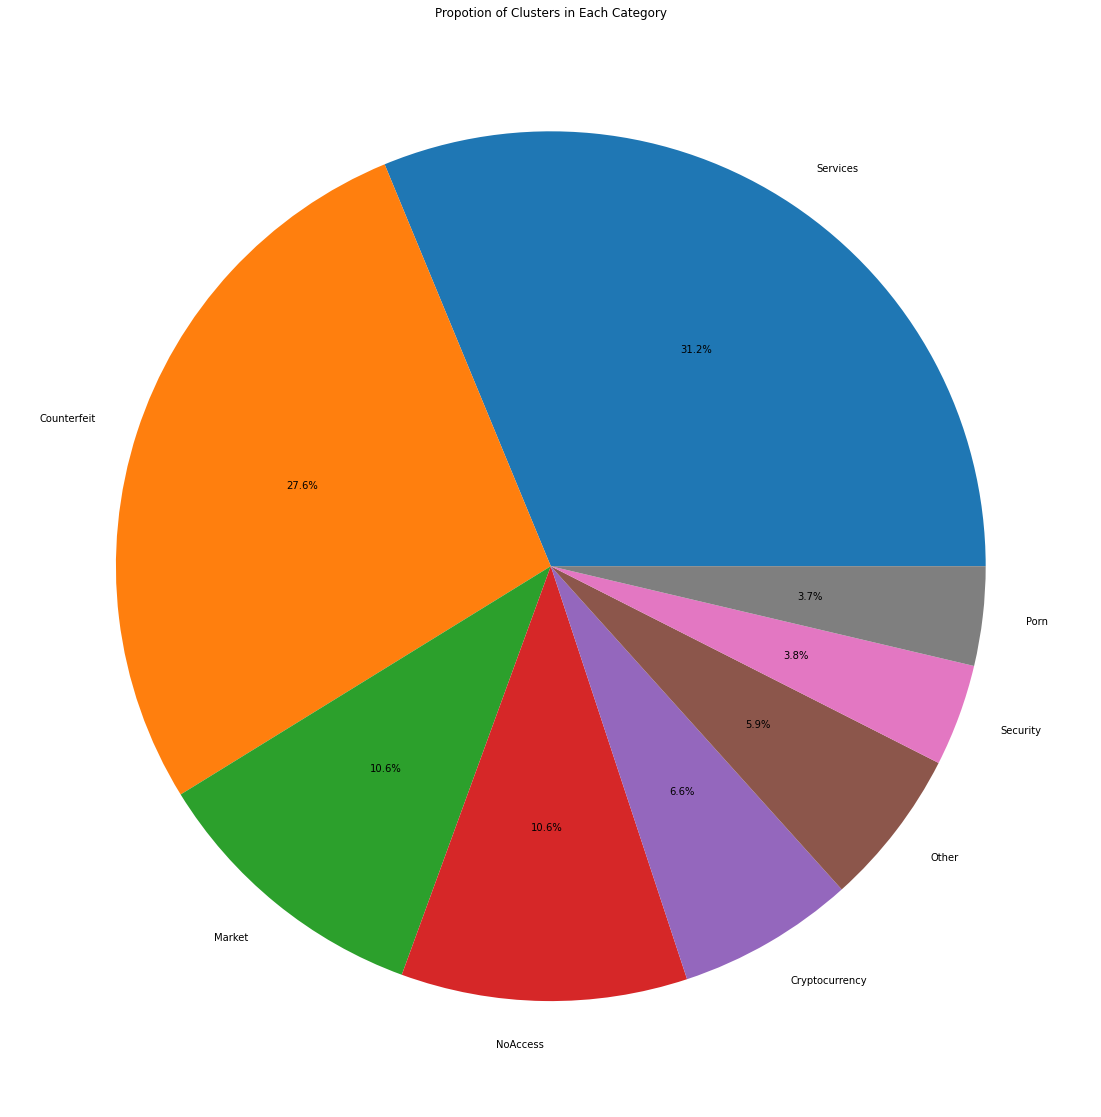

In [21]:
plt.figure(figsize=(20,20))
plt.pie(df_combined_count['title'], labels=df_combined_count['class'], autopct='%1.1f%%')
plt.title("Propotion of Clusters in Each Category")
plt.show()

In [22]:
df_combined.to_csv('../data/model_training_dataset.csv', index=False)

In [ ]:
data = []
for i, row in df_combined.iterrows():
    for url in row['url']:
        temp_row = [url, row['title'], row['body_text'], row['body_token'], row['language'], row['class']]
        data.append(temp_row)
df_split = pd.DataFrame(data)
df_split.rename(columns={0: 'domain_url', 1: 'title', 2: 'body_text', 3: 'body_token', 4: 'language', 5: 'class'}, inplace=True)
df_split

In [ ]:
df_split['domain_url'] = df_split['domain_url'].apply(get_domain)
df_split = df_split[df_split['domain_url'] != 'NA']
df_split.drop_duplicates(subset=['domain_url'], keep='last', inplace=True)
df_split

In [ ]:
df_split.to_csv('../data/model_training_dataset_domain.csv', index=False)